# Tutorial 3 - Boosting Search via Symmetry Breaking, Implied Constraints, Randomisation, and Restarts 'NOTES Perso: inverse implied and redundent + 
revisit the exact parameters so that restars work) 

**Please do not read untill you fully finish the first 2 tutorials**

Congratulations! you are now level one constraint programmer: you know the basics on how to model a problem, how to display solutions, how to evaluate models, and how to choose a good branching strategy !! **I'm so proud of you!**

In this tutorial we slowly dive into advanced techniques. We also start to use arithmetic constraints and solve optimisation problems.

In [1]:
from docplex.cp.model import *
context.solver.agent = 'local'
context.solver.local.execfile = '/Users/msiala/Applications/CPLEX_Studio2211/cpoptimizer/bin/arm64_osx/cpoptimizer'
context.params.set_attribute('Presolve', 'Off')
context.params.set_attribute('Workers', 1)

## Golomb ruler

Your goal is to place $N$ marks on a ruler, such that no two marks are at the same distance and the total length of the ruler (the position of the last mark) is minimized. 

<div class="row" style="margin-top: 10px">
    <img src="display/images/Golomb_Ruler-4.svg" style="display: block; margin: auto; width: 400px;" />
    <p style="margin: auto; margin-top: 10px; text-align: center;">Golomb ruler of order 4 and length 6. This ruler is both optimal and perfect.</p>
</div>

Golomb ruler can be used in information theory to design error correcting codes or in telecommunications to avoid interferences during radio communications. You can read about it here https://en.wikipedia.org/wiki/Golomb_ruler#:~:targetText=In%20mathematics%2C%20a%20Golomb%20ruler,are%20the%20same%20distance%20apart.&targetText=It%20has%20been%20proven%20that,of%20the%20same%20order%20exists.


**In the rest of this tutorial (except the last part), please use the following parameter with the solve method:**

```
SearchType= 'DepthFirst'
```

Also, in order to control the level of filtering (arc consistency, bound consistency, forward checking, etc), CPoptimizer offers to use a parameter called $DefaultInferenceLevel$  http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.parameters.py.html?highlight=defaultinferencelevel#docplex.cp.parameters.CpoParameters.DefaultInferenceLevel

In the rest of this tutorial, you are required to test all three possibilities


```
DefaultInferenceLevel=Low
DefaultInferenceLevel=Medium
DefaultInferenceLevel=Extended

```

After a while, if you see one that you particularly find efficient (runtime), you can use it for the rest of the tutorial. 


Create a model for the decision version of this problem. That is, given $n$ marks, and a ruler of size $m$, place the $n$ markers such that no two markers are at the same distance. 

You are free to use any constraint you want. However, you must declare and use the minimum amount of constraints (**NOT A SINGLE UNNESSASARY CONSTRAINT**)

Note that for N marks, a ruler of length $2 ^ {N -1}$ can be found (I let you figure out why). 

Write a funtion decision_model(n,m) that builds and returns the correspondant model. 

In [2]:
from docplex.cp.model import CpoModel
from docplex.cp.modeler import all_diff, min, max
import numpy as np
import matplotlib.pyplot as plt

def decision_model(m,n):
    model = CpoModel(name="Golomb ruler of order {} and length {}".format(n,m))
    x = model.integer_var_list(n, 0, m, 'x')
    for i in range(n-1):
        model.add(x[i]<x[i+1])    
#     model.add(all_diff(x))  
    model.add(all_diff([x[j]-x[i] for i in range(n) 
                                    for j in range(i+1,n)])) 

    model.print_information()
    model.add(x[-1] == m)
    #model.add(x[0] == 0)
    
    return model,x

In [3]:
model,x = decision_model(6,4)
model.print_information()

Model: Golomb ruler of order 4 and length 6
 - source file: /var/folders/q1/f955m41s7q3gr7vlc1_jtkth0000gs/T/ipykernel_82273/1258366362.py
 - modeling time: 0.00 sec
 - number of integer variables:  4
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        4
 - number of root expressions:   4
 - number of expression nodes:   15
 - operations:                   alldiff: 1, less: 3, minus: 6
Model: Golomb ruler of order 4 and length 6
 - source file: /var/folders/q1/f955m41s7q3gr7vlc1_jtkth0000gs/T/ipykernel_82273/1258366362.py
 - modeling time: 0.00 sec
 - number of integer variables:  4
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        5
 - number of root expressions:   5
 - number of expression nodes:   17
 - operations:                   alldiff: 1

Solve the problem for n=4, m=6. Then try different values of (n,m) (but don't waste too much time). 

In [4]:
sol = model.solve(SearchType='DepthFirst',  DefaultInferenceLevel='Low')
sol.print_solution()

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 4 variables, 5 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Low
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 11.2 (before), 11.2 (after)
 !  . Memory usage      : 267.0 kB (before), 267.0 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed            Branch decision
 *                      4  0.00s                  3 != x_2
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 4
 ! Number of fails        : 1
 ! Total memory usage     : 570.5 kB (530.8 kB CP Optimizer + 

You can display to solution using  :  

```
from display import golomb as display_golomb
display_golomb([sol[m] for m in marks])
```

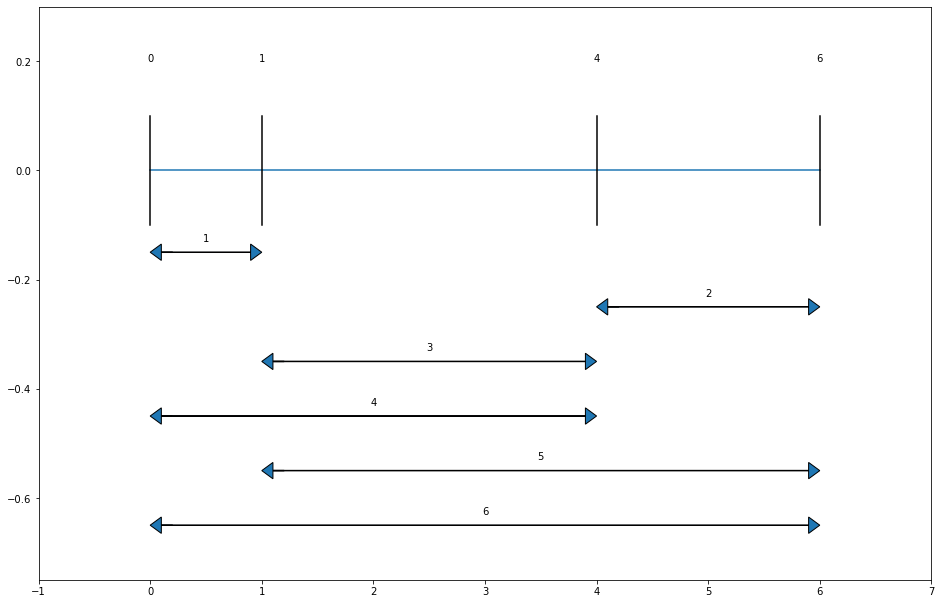

In [5]:
from display import golomb as display_golomb
display_golomb([sol[m] for m in x])

In [6]:
def run_and_display(m,n,InfLevel):
    model,x = decision_model(m,n)
    sol = model.solve(SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
    if sol.get_solve_status() == 'Feasible':
        display_golomb([sol[m] for m in x])

        lsols = model.start_search(SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
        nsol = 0
        for sol in lsols:
            nsol += 1
        print("Total nb of solutions : ", nsol)
    else:
        print('There is no solution!')

Print and display all the sulutions for (n,m) = (4,6) and (4,7)

Model: Golomb ruler of order 4 and length 6
 - source file: /var/folders/q1/f955m41s7q3gr7vlc1_jtkth0000gs/T/ipykernel_82273/1258366362.py
 - modeling time: 0.00 sec
 - number of integer variables:  4
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        4
 - number of root expressions:   4
 - number of expression nodes:   15
 - operations:                   alldiff: 1, less: 3, minus: 6
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 4 variables, 5 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 11.2 (before), 11.2 (after)
 !  . Memory usage      : 267.0 kB (before), 267.0 kB (after)
 ! Using sequential search.
 ! ------------------------------------------

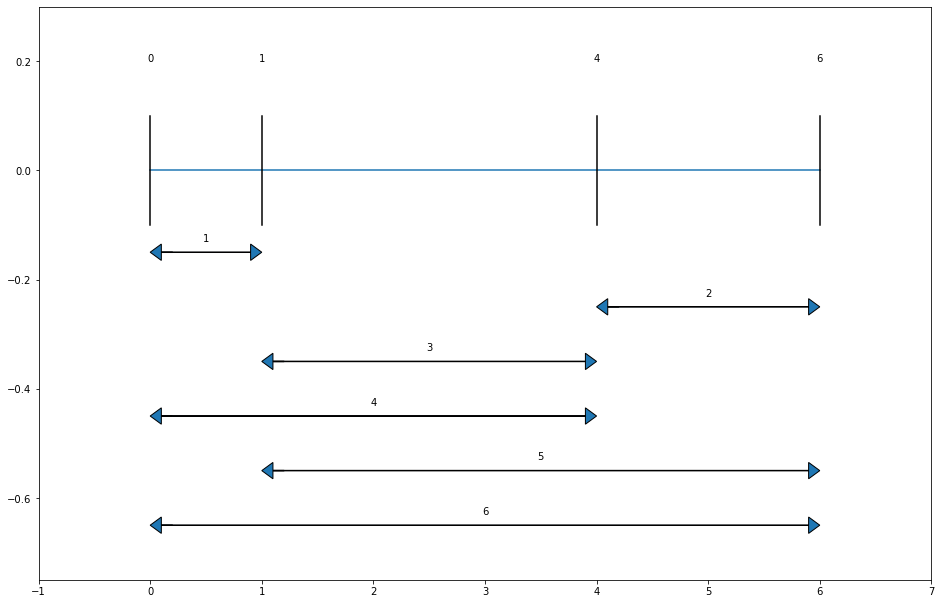

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 4 variables, 5 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 11.2 (before), 11.2 (after)
 !  . Memory usage      : 267.0 kB (before), 267.0 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed            Branch decision
 *                      4  0.00s                  3 != x_2
 *                     10  0.00s                  2  = x_1
 ! ----------------------------------------------------------------------------
 ! Search completed, 2 solutions found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 22
 ! Number of fails        : 10
 ! Total memory usage     : 570

In [7]:
run_and_display(6,4,'Basic')

Model: Golomb ruler of order 4 and length 7
 - source file: /var/folders/q1/f955m41s7q3gr7vlc1_jtkth0000gs/T/ipykernel_82273/1258366362.py
 - modeling time: 0.00 sec
 - number of integer variables:  4
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        4
 - number of root expressions:   4
 - number of expression nodes:   15
 - operations:                   alldiff: 1, less: 3, minus: 6
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 4 variables, 5 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Low
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 12.0 (before), 12.0 (after)
 !  . Memory usage      : 267.0 kB (before), 267.0 kB (after)
 ! Using sequential search.
 ! -----------

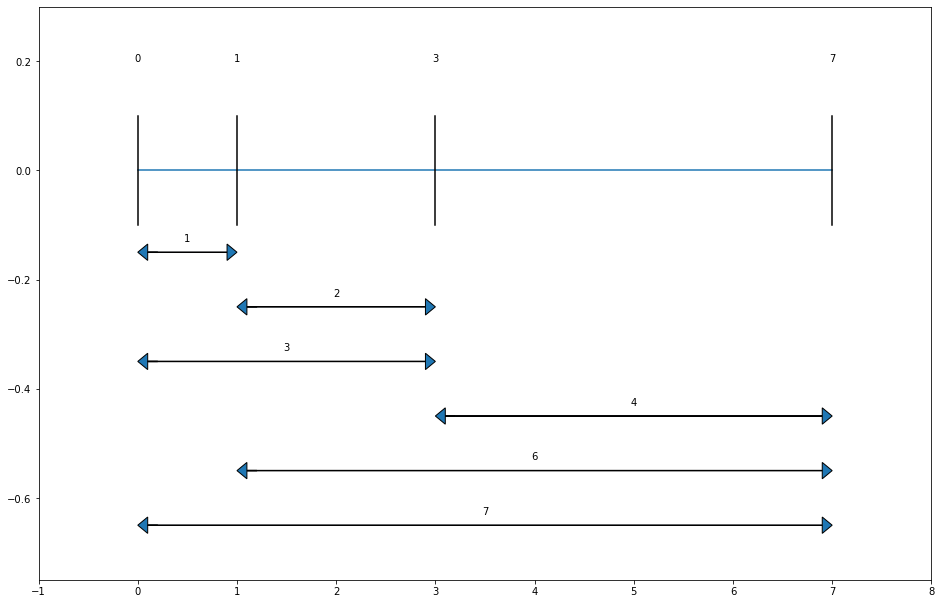

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 4 variables, 5 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Low
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 12.0 (before), 12.0 (after)
 !  . Memory usage      : 267.0 kB (before), 267.0 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed            Branch decision
 *                      3  0.00s                  3  = x_2
 *                      6  0.00s                  4 != x_2
 *                      8  0.00s                  3  = x_2
 *                     12  0.00s                  5  = x_2
 *                     14  0.00s                  2  = x_1
 *                     17  0.00s                  3 != x_1
 *                     22 

In [8]:
run_and_display(7,4,'Low')

In [9]:
run_and_display(10,5,'Basic')

Model: Golomb ruler of order 5 and length 10
 - source file: /var/folders/q1/f955m41s7q3gr7vlc1_jtkth0000gs/T/ipykernel_82273/1258366362.py
 - modeling time: 0.00 sec
 - number of integer variables:  5
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        5
 - number of root expressions:   5
 - number of expression nodes:   21
 - operations:                   alldiff: 1, less: 4, minus: 10
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 5 variables, 6 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 17.3 (before), 17.3 (after)
 !  . Memory usage      : 267.0 kB (before), 267.0 kB (after)
 ! Using sequential search.
 ! ----------------------------------------

Write a funtion  basic_optimisation_model(n) that builds and returns the correspondant model for the
optimisation problem. Note that an optimisation function can be seen as a variable. In order to specify the variable to optimise, we can simply use : 

```
model.add(model.minimize(myvariable))
```

or 

```
model.add(model.maximize(myvariable))
```


In [10]:
def basic_optimisation_model(n):
    model = CpoModel(name="The shortest Golomb ruler of order {} ".format(n))
    x = model.integer_var_list(n, 0, n*n, 'x') ## G(n) <= n^2
    
    for i in range(n-1):
        model.add(x[i] < x[i+1]) 
    model.add(all_diff([x[i]-x[j] for i in range(n) for j in range(i)])) 

    model.add(model.minimize(x[-1]))
    return model,x

In [11]:
test_model, x  = basic_optimisation_model(6)
test_model.print_information()

Model: The shortest Golomb ruler of order 6 
 - source file: /var/folders/q1/f955m41s7q3gr7vlc1_jtkth0000gs/T/ipykernel_82273/1983510843.py
 - modeling time: 0.00 sec
 - number of integer variables:  6
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        7
 - number of root expressions:   7
 - number of expression nodes:   29
 - operations:                   alldiff: 1, less: 5, minimize: 1, minus: 15


 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 6 variables, 6 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Low
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 31.3 (before), 31.3 (after)
 !  . Memory usage      : 299.2 kB (before), 299.2 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          6                 -
 + New bound is 0
 *            21      196  0.00s               (gap is 100.0%)
 *            20      277  0.00s               (gap is 100.0%)
 *            18      286  0.00s               (gap is 100.0%)
 *            17      337  0.00s               (gap is 100.0%)
 ! ------------------------------------------------------

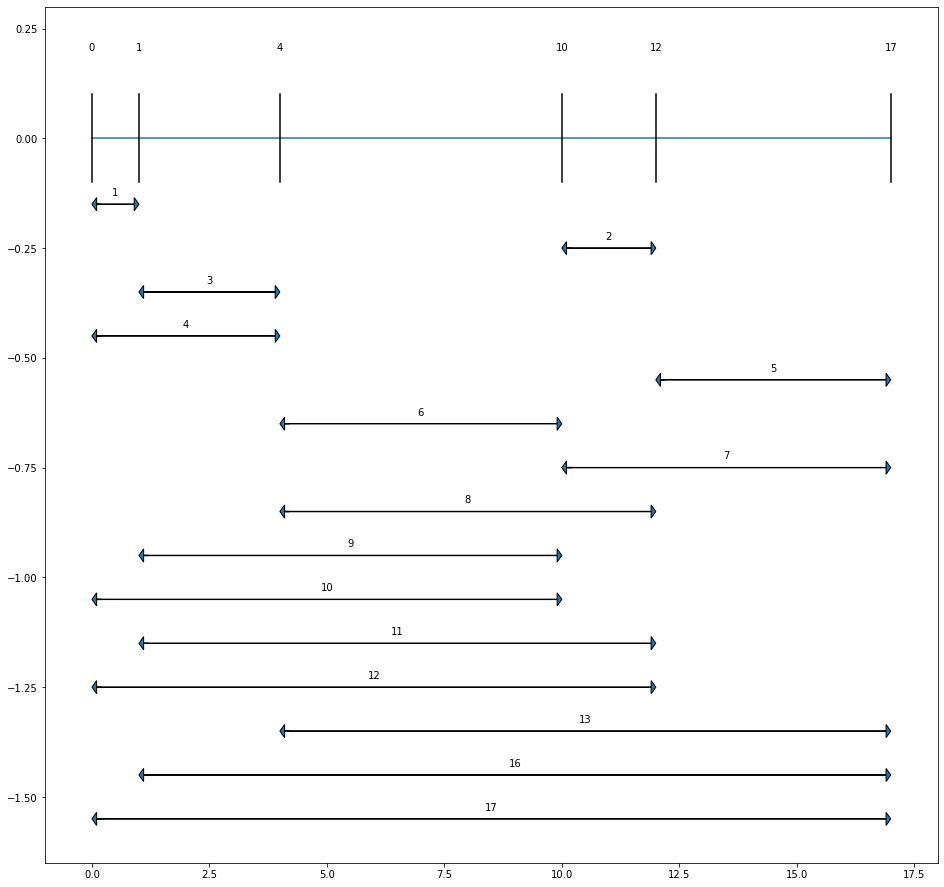

In [12]:
sol = test_model.solve(SearchType='DepthFirst',  DefaultInferenceLevel='Low')
sol.print_solution()
display_golomb([sol[m] for m in x])

In [13]:
sol.get_objective_values()[0]

17

Solve the optimisation problem for N=6.. 10  and display the solution

In [14]:
def run_basic_model(n,InfLevel):
    print("Build basic model...")
    model,x = basic_optimisation_model(n)
    sol = model.solve(SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
    # sol.print_solution()
    infos = sol.get_solver_infos()
    if sol.get_solve_status() == 'Optimal':
        print("The shortest Golomb ruler of order {} is = {}, total execution time = {}s".format(n,sol.get_objective_values()[0],infos['TotalTime']))
    else:
        print('There is no solution!')
    return model,x,sol

In [15]:
for n in range(4,10):
    _,_,_ = run_basic_model(n,'Low')

Build basic model...
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 4 variables, 4 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Low
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 16.3 (before), 16.3 (after)
 !  . Memory usage      : 267.1 kB (before), 267.1 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          4                 -
 + New bound is 0
 *             7        4  0.00s               (gap is 100.0%)
 *             6        7  0.00s               (gap is 100.0%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 2 solutions found.
 ! Best objective         : 6 (optimal - e

                    11000          3        F     8  = x_3
                    12000          3        F     4 != x_2
                    13000          3             12 != x_3
                    14000          3        F    16  = x_4
 *            45    14158  0.03s               (gap is 100.0%)
              45    15000          1              3  = x_1
              45    16000          3              4 != x_2
              45    17000          3        F     8  = x_4
              45    18000          3        F     8  = x_3
 ! Time = 0.04s, Average fail depth = 5, Memory usage = 595.2 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
              45    19000          3              5 != x_0
 *            42    19142  0.05s               (gap is 100.0%)
              42    20000          2             15 != x_3
 *            41    20858  0.05s               (gap is 100.0%)
              41    21000          3        F     2  =

                    21000          4              5  = x_1
                    22000          4              2 != x_2
                    23000          4        F     3 != x_1
                    24000          4        F     7  = x_3
                    25000          3        F    13 != x_3
                    26000          3        F     2 != x_1
                    27000          4              2 != x_1
                    28000          4             19 != x_5
                    29000          4              4 != x_2
                    30000          4        F    16 != x_3
                    31000          4        F     8 != x_2
                    32000          3        F    22  = x_5
                    33000          3              1 != x_0
                    34000          3        F     5  = x_2
                    35000          3        F     3  = x_3
                    36000          4        F     2 != x_0
                    37000          4        F    11  = x

              58     144k          3              9 != x_5
              58     145k          4             11 != x_5
              58     146k          4        F     8 != x_3
              58     147k          3              0  = x_0
              58     148k          4        F     9 != x_3
              58     149k          3             10  = x_4
              58     150k          3             12 != x_3
              58     151k          3        F     8  = x_2
              58     152k          3        F     8  = x_1
              58     153k          3             11 != x_4
              58     154k          3        F    18  = x_3
              58     155k          3        F     5  = x_2
              58     156k          3              7  = x_0
 *            57     156k  0.48s               (gap is 100.0%)
              57     157k          3        F    12  = x_3
 ! Time = 0.48s, Average fail depth = 6, Memory usage = 637.3 kB
 ! Current bound is 0 (gap is 100.0%)
 !      

              49     262k          3              3 != x_0
              49     263k          3        F    15  = x_2
              49     264k          3        F     7  = x_1
              49     265k          3        F    16  = x_2
              49     266k          3             12 != x_5
              49     267k          3             15 != x_3
              49     268k          3              5  = x_0
              49     269k          3        F    19 != x_3
              49     270k          3              9 != x_2
              49     271k          3             19 != x_3
              49     272k          3             14 != x_2
              49     273k          3        F     6  = x_1
              49     274k          3        F     6  = x_2
 ! Time = 0.89s, Average fail depth = 6, Memory usage = 670.3 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
              49     275k          3        F    11  = x_3
       

              48     383k          3              7 != x_2
              48     384k          3              6 != x_1
              48     385k          3        F     2 != x_1
              48     386k          3              5 != x_2
              48     387k          2              6 != x_2
 *            47     387k  1.28s               (gap is 100.0%)
              47     388k          3             13 != x_3
              47     389k          2             20 != x_4
              47     390k          3        F    28  = x_4
              47     391k          2             20 != x_4
              47     392k          3        F     4  = x_2
 ! Time = 1.30s, Average fail depth = 6, Memory usage = 671.4 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
              47     393k          4        F     7  = x_4
              47     394k          4              3 != x_2
              47     395k          3              4  = x_1
   

              47     504k          4             10 != x_3
              47     505k          3              2 != x_1
              47     506k          3        F     3  = x_2
              47     507k          3        F    17 != x_3
              47     508k          3              3 != x_1
              47     509k          3        F     9  = x_3
              47     510k          3             16 != x_4
              47     511k          3             13 != x_4
              47     512k          3             20 != x_4
 ! Time = 1.72s, Average fail depth = 6, Memory usage = 703.5 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
              47     513k          3              9 != x_3
              47     514k          3        F     7  = x_3
              47     515k          3        F    13  = x_3
              47     516k          3              3 != x_0
              47     517k          3        F     6  = x_0
       

              45     625k          2              8  = x_4
              45     626k          3        F    12  = x_2
              45     627k          3              5  = x_1
              45     628k          3              1 != x_0
              45     629k          2        F    14  = x_2
              45     630k          3             22 != x_4
              45     631k          3              0 != x_0
 ! Time = 2.12s, Average fail depth = 6, Memory usage = 703.5 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
              45     632k          2              6 != x_3
              45     633k          3             21  = x_4
              45     634k          3              1 != x_1
              45     635k          2        F     3  = x_1
              45     636k          2             20 != x_2
              45     637k          2             18 != x_3
              45     638k          3        F    20  = x_4
       

In [16]:
for n in range(4,10):
    _,_,_ = run_basic_model(n,'Medium')

Build basic model...
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 4 variables, 4 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Medium
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 16.3 (before), 16.3 (after)
 !  . Memory usage      : 267.1 kB (before), 267.1 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          4                 -
 + New bound is 0
 *             7        4  0.00s               (gap is 100.0%)
 *             6        6  0.00s               (gap is 100.0%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 2 solutions found.
 ! Best objective         : 6 (optimal 

              41    12000          3              0 != x_0
              41    13000          3              8 != x_2
              41    14000          3        F    11 != x_3
              41    15000          3             18 != x_4
              41    16000          2             13 != x_1
 ! Time = 0.07s, Average fail depth = 5, Memory usage = 628.0 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
 *            40    16025  0.07s               (gap is 100.0%)
 *            39    16061  0.07s               (gap is 100.0%)
              39    17000          2        F     9 != x_2
              39    18000          2        F     8  = x_5
              39    19000          3              4 != x_3
 *            37    19999  0.09s               (gap is 100.0%)
              37    20000          2              4 != x_2
              37    21000          3        F    17 != x_2
 *            35    21526  0.09s               (gap is

                    62000          4        F     9  = x_3
                    63000          3              3 != x_0
                    64000          3        F     3  = x_1
                    65000          4              3 != x_1
                    66000          3              6 != x_2
                    67000          3        F    12 != x_4
                    68000          3        F     7 != x_1
                    69000          3              3  = x_1
                    70000          3        F     8  = x_4
                    71000          3        F    19  = x_4
                    72000          3        F     8  = x_3
                    73000          3        F    17  = x_4
                    74000          3        F    10  = x_2
                    75000          3        F     5  = x_2
                    76000          3        F     4  = x_2
 *            58    76021  0.37s               (gap is 100.0%)
              58    77000          1        F     3 

              48     178k          3              4 != x_2
              48     179k          3             11 != x_3
              48     180k          3        F    23 != x_3
              48     181k          3             12 != x_3
              48     182k          3             16 != x_5
              48     183k          4             18 != x_4
              48     184k          4        F     9  = x_4
              48     185k          4        F     7 != x_3
              48     186k          4        F     6  = x_3
              48     187k          4             21  = x_4
              48     188k          3        F    16  = x_4
              48     189k          3              8 != x_3
              48     190k          3             15 != x_4
              48     191k          3              5 != x_3
              48     192k          3              6 != x_2
              48     193k          3        F    17  = x_4
 ! Time = 1.01s, Average fail depth = 6, Memory usage = 

              47     299k          3        F    17 != x_4
              47     300k          3             10 != x_3
              47     301k          3              8 != x_4
              47     302k          3              7 != x_4
              47     303k          3              5 != x_2
              47     304k          3        F    16  = x_4
              47     305k          3        F    11  = x_2
              47     306k          3              2 != x_1
              47     307k          3              3 != x_2
              47     308k          3             15 != x_4
              47     309k          3        F    25  = x_4
              47     310k          3        F    10  = x_3
              47     311k          3        F     9  = x_4
              47     312k          4              9 != x_2
 ! Time = 1.66s, Average fail depth = 6, Memory usage = 670.5 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
       

              44     419k          3        F    11  = x_2
              44     420k          2        F    11  = x_3
              44     421k          3        F    23  = x_4
              44     422k          2              9 != x_3
 ! ----------------------------------------------------------------------------
 ! Search completed, 9 solutions found.
 ! Best objective         : 44 (optimal - effective tol. is 0)
 ! Best bound             : 0
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 422288
 ! Number of fails        : 211136
 ! Total memory usage     : 743.5 kB (703.2 kB CP Optimizer + 40.3 kB Concert)
 ! Time spent in solve    : 2.24s (2.24s engine + 0.00s extraction)
 ! Search speed (br. / s) : 188521.4
 ! ----------------------------------------------------------------------------
The shortest Golomb ruler of order 9 is = 44, total execution time = 2.24s


In [17]:
for n in range(4,10):
    _,_,_ = run_basic_model(n,'Extended')

Build basic model...
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 4 variables, 4 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Extended
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 16.3 (before), 16.3 (after)
 !  . Memory usage      : 267.1 kB (before), 267.1 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          4                 -
 + New bound is 0
 *             7        4  0.00s               (gap is 100.0%)
 *             6        6  0.00s               (gap is 100.0%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 2 solutions found.
 ! Best objective         : 6 (optima

              41    12000          3              0 != x_0
              41    13000          3              8 != x_2
              41    14000          3        F    11 != x_3
              41    15000          3             18 != x_4
              41    16000          2             13 != x_1
 ! Time = 0.09s, Average fail depth = 5, Memory usage = 660.0 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
 *            40    16025  0.09s               (gap is 100.0%)
 *            39    16061  0.09s               (gap is 100.0%)
              39    17000          2        F     9 != x_2
              39    18000          2        F     8  = x_5
              39    19000          3              4 != x_3
 *            37    19999  0.11s               (gap is 100.0%)
              37    20000          2              4 != x_2
              37    21000          3        F    17 != x_2
 *            35    21526  0.12s               (gap is

                    62000          4        F     9  = x_3
                    63000          3              3 != x_0
                    64000          3        F     3  = x_1
                    65000          4              3 != x_1
                    66000          3              6 != x_2
                    67000          3        F    12 != x_4
                    68000          3        F     7 != x_1
                    69000          3              3  = x_1
                    70000          3        F     8  = x_4
                    71000          3        F    19  = x_4
                    72000          3        F     8  = x_3
                    73000          3        F    17  = x_4
                    74000          3        F    10  = x_2
                    75000          3        F     5  = x_2
                    76000          3        F     4  = x_2
 *            58    76021  0.50s               (gap is 100.0%)
              58    77000          1        F     3 

              48     178k          3              4 != x_2
              48     179k          3             11 != x_3
              48     180k          3        F    23 != x_3
              48     181k          3             12 != x_3
              48     182k          3             16 != x_5
              48     183k          4             18 != x_4
              48     184k          4        F     9  = x_4
              48     185k          4        F     7 != x_3
              48     186k          4        F     6  = x_3
              48     187k          4             21  = x_4
              48     188k          3        F    16  = x_4
              48     189k          3              8 != x_3
              48     190k          3             15 != x_4
              48     191k          3              5 != x_3
              48     192k          3              6 != x_2
              48     193k          3        F    17  = x_4
 ! Time = 1.26s, Average fail depth = 6, Memory usage = 

              47     299k          3        F    17 != x_4
              47     300k          3             10 != x_3
              47     301k          3              8 != x_4
              47     302k          3              7 != x_4
              47     303k          3              5 != x_2
              47     304k          3        F    16  = x_4
              47     305k          3        F    11  = x_2
              47     306k          3              2 != x_1
              47     307k          3              3 != x_2
              47     308k          3             15 != x_4
              47     309k          3        F    25  = x_4
              47     310k          3        F    10  = x_3
              47     311k          3        F     9  = x_4
              47     312k          4              9 != x_2
 ! Time = 2.01s, Average fail depth = 6, Memory usage = 702.5 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
       

              44     419k          3        F    11  = x_2
              44     420k          2        F    11  = x_3
              44     421k          3        F    23  = x_4
              44     422k          2              9 != x_3
 ! ----------------------------------------------------------------------------
 ! Search completed, 9 solutions found.
 ! Best objective         : 44 (optimal - effective tol. is 0)
 ! Best bound             : 0
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 422288
 ! Number of fails        : 211136
 ! Total memory usage     : 775.5 kB (735.2 kB CP Optimizer + 40.3 kB Concert)
 ! Time spent in solve    : 2.70s (2.70s engine + 0.00s extraction)
 ! Search speed (br. / s) : 156984.4
 ! ----------------------------------------------------------------------------
The shortest Golomb ruler of order 9 is = 44, total execution time = 2.69s


# Symmetry Breaking

In combinatorial optimisation, two (partial) solutions are called symmetric if we can find a transformation from one to the other. 
Consider our golomb ruler problem. Given any solution to the marks variables, if the first mark is not at index $0$, we can always shift everything to the left to start from $0$ and still have a solution. 

Constraint programming is extremely flexible to handle symmetries since they can be declared as constraints. 

In the case of the above symmetry, we can simply add 
```
model.add (marks[0]==0)
```

This problem has another symmetry, can you find it? In order to help you, display the solution for n=4 and m=6 for the decision problem. You should find 2 solutions that are essentially the same. Can you find the symmetry? How can we model this symmetry as a constraint? 

Model: Golomb ruler of order 4 and length 6
 - source file: /var/folders/q1/f955m41s7q3gr7vlc1_jtkth0000gs/T/ipykernel_82273/1258366362.py
 - modeling time: 0.00 sec
 - number of integer variables:  4
 - number of interval variables: 0
 - number of sequence variables: 0
 - number of state functions:    0
 - number of float variables:    0
 - number of constraints:        4
 - number of root expressions:   4
 - number of expression nodes:   15
 - operations:                   alldiff: 1, less: 3, minus: 6
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 4 variables, 5 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Low
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 11.2 (before), 11.2 (after)
 !  . Memory usage      : 267.0 kB (before), 267.0 kB (after)
 ! Using sequential search.
 ! -----------

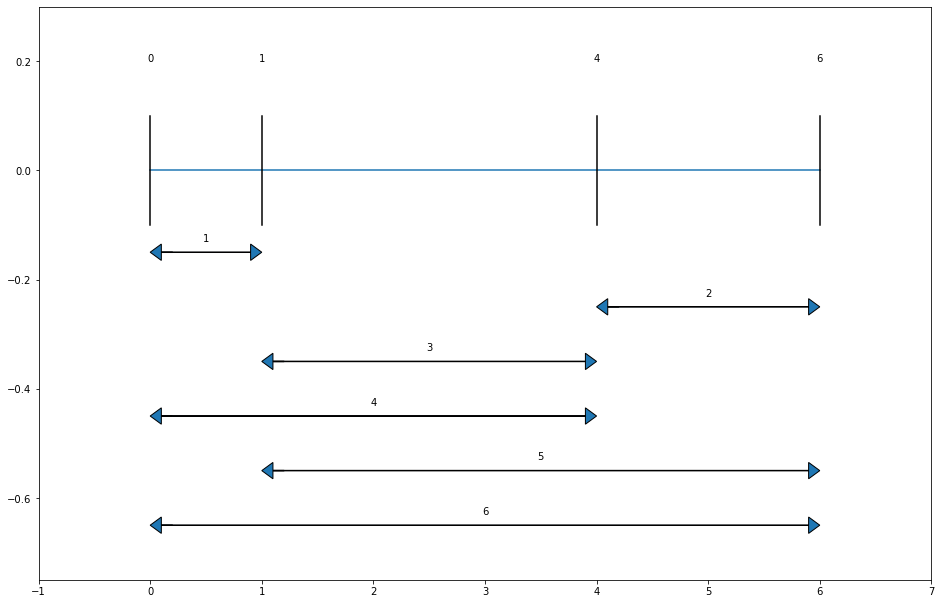

 *                     10  0.00s                  2  = x_1


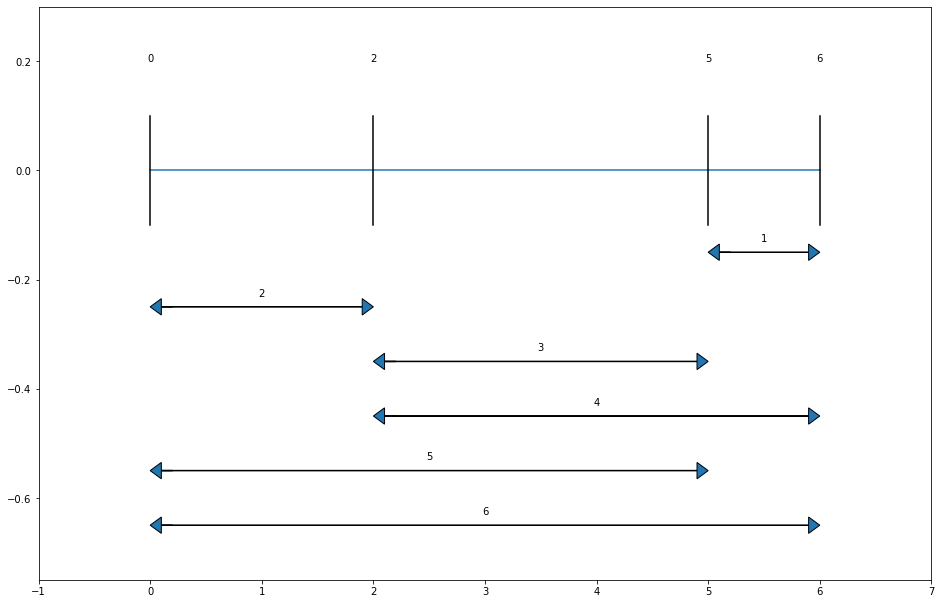

 ! ----------------------------------------------------------------------------
 ! Search completed, 2 solutions found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 22
 ! Number of fails        : 10
 ! Total memory usage     : 570.8 kB (531.1 kB CP Optimizer + 39.7 kB Concert)
 ! Time spent in solve    : 0.00s (0.00s engine + 0.00s extraction)
 ! Search speed (br. / s) : 2200.0
 ! ----------------------------------------------------------------------------


In [18]:
model,x = decision_model(6,4) 
lsols = model.start_search(SearchType='DepthFirst',  DefaultInferenceLevel='Low')
for sol in lsols:
    display_golomb([sol[m] for m in x])

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Satisfiability problem - 4 variables, 7 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Low
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 11.2 (before), 11.2 (after)
 !  . Memory usage      : 267.0 kB (before), 267.0 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed            Branch decision
 *                      4  0.00s                  3 != x_2


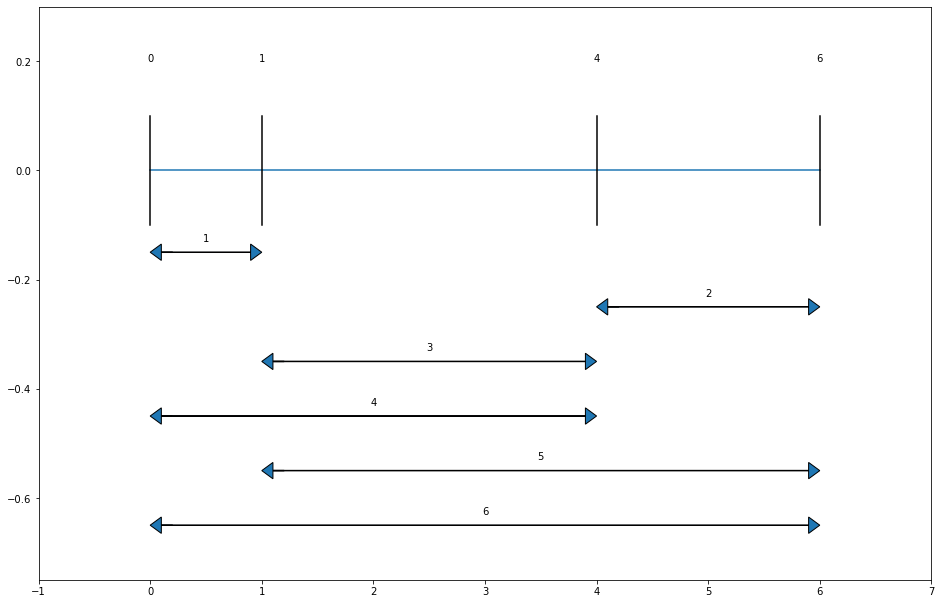

 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 4
 ! Number of fails        : 2
 ! Total memory usage     : 569.5 kB (529.8 kB CP Optimizer + 39.7 kB Concert)
 ! Time spent in solve    : 0.00s (0.00s engine + 0.00s extraction)
 ! Search speed (br. / s) : 400.0
 ! ----------------------------------------------------------------------------


In [19]:
model.add(x[0] == 0)
model.add(x[1]-x[0] < x[-1]-x[-2])
lsols = model.start_search(SearchType='DepthFirst',  DefaultInferenceLevel='Low')
for sol in lsols:
    display_golomb([sol[m] for m in x])

Write a new function nosymmetry_optimisation_model(n) that builds a new model that avoids the two symmetries we found so far. 

In [20]:
def nosymmetry_optimisation_model(n):
    model = CpoModel(name="The shortest Golomb ruler of order {} - Symmetry Breaking".format(n))
    marks = model.integer_var_list(n, 0, n*n, 'x') ## G(n) <= n^2
    
    model.add(marks[0] == 0)
    for i in range(n-1):
        model.add(marks[i] < marks[i+1])
                         
    if n > 2 : 
        model.add(marks[1]-marks[0] < marks[n-1]-marks[n-2]) ## 2nd symmetry constraint
        
    model.add(all_diff([marks[i]-marks[j] for i in range(n) for j in range(i)])) 

    model.add(model.minimize(marks[n-1]))
    return model,marks

In [21]:
def run_nosymmetry_model(n,InfLevel):
    print("Build no symmetry model...")
    model,x = nosymmetry_optimisation_model(n)
    sol = model.solve(TimeLimit=120, LogPeriod = 100000,SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
    infos = sol.get_solver_infos()
    if sol.get_solve_status() == 'Optimal':
        print("The shortest Golomb ruler of order {} is = {}, total execution time = {}s".format(n,sol.get_objective_values()[0],infos['TotalTime']))
    else:
        print('There is no solution!')
    return model,x,sol

Compare nosymmetry_optimisation_model and basic_optimisation_model for different values of $n$ (you decide the values of $n$). Plot the runtime and the search tree size

In [22]:
basic_runtime, nosym_runtime = [],[]
basic_treesize, nosym_treesize = [],[]
n_settings = np.arange(4,10,1)

for n in n_settings:
    _,_,basic_sol = run_basic_model(n,"Low")
    _,_,nosym_sol = run_nosymmetry_model(n,"Low")
    
    basic_runtime.append(basic_sol.get_solver_infos()['TotalTime'])
    basic_treesize.append(basic_sol.get_solver_infos()['NumberOfChoicePoints'])
    nosym_runtime.append(nosym_sol.get_solver_infos()['TotalTime'])
    nosym_treesize.append(nosym_sol.get_solver_infos()['NumberOfChoicePoints'])

Build basic model...
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 4 variables, 4 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! DefaultInferenceLevel = Low
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 16.3 (before), 16.3 (after)
 !  . Memory usage      : 267.1 kB (before), 267.1 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          4                 -
 + New bound is 0
 *             7        4  0.00s               (gap is 100.0%)
 *             6        7  0.00s               (gap is 100.0%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 2 solutions found.
 ! Best objective         : 6 (optimal - e

 ! TimeLimit            = 120
 ! Workers              = 1
 ! DefaultInferenceLevel = Low
 ! LogPeriod            = 100000
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 31.3 (before), 31.3 (after)
 !  . Memory usage      : 299.5 kB (before), 299.5 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          6                 -
 + New bound is 0
 *            23       48  0.00s               (gap is 100.0%)
 *            20       55  0.00s               (gap is 100.0%)
 *            18       57  0.00s               (gap is 100.0%)
 *            17       61  0.00s               (gap is 100.0%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 4 solutions found.
 ! Best objective         : 17 (optim

              39    28000          2        F    22 != x_4
              39    29000          3              2 != x_0
              39    30000          3        F     5  = x_2
              39    31000          2        F     6  = x_1
              39    32000          3        F     0  = x_0
              39    33000          3              6 != x_3
              39    34000          2        F     4  = x_1
 ! Time = 0.09s, Average fail depth = 5, Memory usage = 628.7 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
              39    35000          2        F     9  = x_3
 *            37    35008  0.09s               (gap is 100.0%)
              37    36000          3              8 != x_1
              37    37000          2        F    16 != x_3
              37    38000          3             12  = x_4
 *            35    38150  0.10s               (gap is 100.0%)
              35    39000          2        F     2  = x_1

                    15000          4              3  = x_1
                    16000          4             13 != x_4
                    17000          4              2 != x_1
                    18000          4              7 != x_3
                    19000          4             18  = x_4
 ! Time = 0.06s, Average fail depth = 5, Memory usage = 627.4 kB
 ! Current bound is 0
 !          Best Branches  Non-fixed            Branch decision
                    20000          4        F     8  = x_4
                    21000          4              5  = x_1
                    22000          4              2 != x_2
                    23000          4        F     3 != x_1
                    24000          4        F     7  = x_3
                    25000          3        F    13 != x_3
                    26000          3        F     2 != x_1
                    27000          4              2 != x_1
                    28000          4             19 != x_5
                    290

              58     138k          3              2  = x_0
 ! Time = 0.41s, Average fail depth = 6, Memory usage = 634.1 kB
 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
              58     139k          3              3 != x_3
              58     140k          3        F    10  = x_3
              58     141k          3        F    15 != x_3
              58     142k          3        F    20 != x_3
              58     143k          3             11 != x_3
              58     144k          3              9 != x_5
              58     145k          4             11 != x_5
              58     146k          4        F     8 != x_3
              58     147k          3              0  = x_0
              58     148k          4        F     9 != x_3
              58     149k          3             10  = x_4
              58     150k          3             12 != x_3
              58     151k          3        F     8  = x_2
       

 ! Current bound is 0 (gap is 100.0%)
 !          Best Branches  Non-fixed            Branch decision
              49     255k          3             11 != x_2
              49     256k          3              0  = x_0
              49     257k          3             14  = x_4
              49     258k          3        F    14  = x_3
              49     259k          3        F    18  = x_4
              49     260k          3             15 != x_4
              49     261k          3        F     9 != x_3
              49     262k          3              3 != x_0
              49     263k          3        F    15  = x_2
              49     264k          3        F     7  = x_1
              49     265k          3        F    16  = x_2
              49     266k          3             12 != x_5
              49     267k          3             15 != x_3
              49     268k          3              5  = x_0
              49     269k          3        F    19 != x_3
             

              48     375k          3        F     1  = x_1
              48     376k          3        F    17  = x_3
              48     377k          2             29  = x_5
              48     378k          2              9 != x_2
              48     379k          3             10 != x_2
              48     380k          3        F    16  = x_3
              48     381k          2             12  = x_5
              48     382k          3        F     5  = x_2
              48     383k          3              7 != x_2
              48     384k          3              6 != x_1
              48     385k          3        F     2 != x_1
              48     386k          3              5 != x_2
              48     387k          2              6 != x_2
 *            47     387k  1.28s               (gap is 100.0%)
              47     388k          3             13 != x_3
              47     389k          2             20 != x_4
              47     390k          3        F    28 

              47     496k          3        F     5  = x_1
              47     497k          3        F     6 != x_3
              47     498k          2              8 != x_4
              47     499k          3              0  = x_0
              47     500k          4        F    13  = x_3
              47     501k          3             11  = x_4
              47     502k          3        F     7  = x_2
              47     503k          3             15  = x_4
              47     504k          4             10 != x_3
              47     505k          3              2 != x_1
              47     506k          3        F     3  = x_2
              47     507k          3        F    17 != x_3
              47     508k          3              3 != x_1
              47     509k          3        F     9  = x_3
              47     510k          3             16 != x_4
              47     511k          3             13 != x_4
              47     512k          3             20 != x

              45     617k          3        F    10  = x_2
              45     618k          2              1  = x_0
              45     619k          3        F    13 != x_3
              45     620k          3              1  = x_0
              45     621k          3        F    12  = x_4
              45     622k          2        F    21  = x_4
              45     623k          2              6 != x_1
              45     624k          3             11 != x_4
              45     625k          2              8  = x_4
              45     626k          3        F    12  = x_2
              45     627k          3              5  = x_1
              45     628k          3              1 != x_0
              45     629k          2        F    14  = x_2
              45     630k          3             22 != x_4
              45     631k          3              0 != x_0
 ! Time = 2.11s, Average fail depth = 6, Memory usage = 703.5 kB
 ! Current bound is 0 (gap is 100.0%)
 !          

What's your impression about symmetries? 

## Implied Constraints

An implied constraint is one that can be dedused by looking at the original constraints of the problem. 

For instance, if we have $a<b $ and $b<c$, one can infer that $a<c$. 

Such constraints (called also redundant constraints) can help the solver to prune further the search tree. 



In our problem there is an implied constraint. Can you find it? Please check with of the supervisors. 



Write a new function nosymmetry2_optimisation_model(n) that adds the implied constraint to the nosymmetry_optimisation_model(n) and returns the new model 

In [23]:
def nosymmetry2_optimisation_model(n):
    model = CpoModel(name="The shortest Golomb ruler of order {} - Symmetry Breaking".format(n))
    marks = model.integer_var_list(n, 0, n*n, 'x') ## G(n) <= n^2
    
    model.add(marks[0] == 0)
    for i in range(n-1):
        model.add(marks[i] < marks[i+1])
            
    if n > 2 :
        model.add(marks[1]-marks[0] < marks[n-1]-marks[n-2]) ## no symmetry constraint

    model.add(all_diff(marks))
    model.add(all_diff([marks[i]-marks[j] for i in range(n) for j in range(i)])) 
    
    model.add(model.minimize(marks[n-1]))
    return model,marks

In [24]:
def run_nosymmetry2_model(n,InfLevel):
    print("Build no symmetry model version 2 (with implied constraints)...")
    model,x = nosymmetry2_optimisation_model(n)
    sol = model.solve(TimeLimit=120, LogPeriod = 100000,SearchType='DepthFirst',  DefaultInferenceLevel=InfLevel)
    infos = sol.get_solver_infos()
    if sol.get_solve_status() == 'Optimal':
        print("The shortest Golomb ruler of order {} is = {}, total execution time = {}s".format(n,sol.get_objective_values()[0],infos['TotalTime']))
    else:
        print('There is no solution!')
    return model,x,sol

Compare nosymmetry2_optimisation_model and nosymmetry_optimisation_model 

In [25]:
nosym2_runtime, nosym_runtime = [],[]
nosym2_treesize, nosym_treesize = [],[]
n_settings = np.arange(4,12,1)

for n in n_settings:
    _,_,nosym_sol = run_nosymmetry_model(n,"Extended")
    _,_,nosym2_sol = run_nosymmetry2_model(n,"Extended")
    
    nosym_runtime.append(nosym_sol.get_solver_infos()['TotalTime'])
    nosym_treesize.append(nosym_sol.get_solver_infos()['NumberOfChoicePoints'])
    nosym2_runtime.append(nosym2_sol.get_solver_infos()['TotalTime'])
    nosym2_treesize.append(nosym2_sol.get_solver_infos()['NumberOfChoicePoints'])

Build no symmetry model...
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 4 variables, 6 constraints
 ! Presolve             = Off
 ! TimeLimit            = 120
 ! Workers              = 1
 ! DefaultInferenceLevel = Extended
 ! LogPeriod            = 100000
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 16.3 (before), 16.3 (after)
 !  . Memory usage      : 267.1 kB (before), 267.1 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          4                 -
 + New bound is 0
 *             7        3  0.00s               (gap is 100.0%)
 *             6        5  0.00s               (gap is 100.0%)
 ! ----------------------------------------------------------------------------
 ! Searc

The shortest Golomb ruler of order 6 is = 17, total execution time = 0s
Build no symmetry model version 2 (with implied constraints)...
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 6 variables, 9 constraints
 ! Presolve             = Off
 ! TimeLimit            = 120
 ! Workers              = 1
 ! DefaultInferenceLevel = Extended
 ! LogPeriod            = 100000
 ! SearchType           = DepthFirst
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 31.3 (before), 31.3 (after)
 !  . Memory usage      : 299.5 kB (before), 299.5 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0          6                 -
 + New bound is 0
 *            23       34  0.00s               (gap is 100.0%)
 *            20       46  0.00s          

                        0          8                 -
 + New bound is 0
 *            51     1065  0.01s               (gap is 100.0%)
 *            42     1328  0.01s               (gap is 100.0%)
 *            41     1419  0.01s               (gap is 100.0%)
 *            40     1825  0.02s               (gap is 100.0%)
 *            39     2310  0.02s               (gap is 100.0%)
 *            36     2964  0.03s               (gap is 100.0%)
 *            35     4306  0.03s               (gap is 100.0%)
 *            34     4574  0.04s               (gap is 100.0%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 8 solutions found.
 ! Best objective         : 34 (optimal - effective tol. is 0)
 ! Best bound             : 0
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 8630
 ! Number of fails        : 4308
 ! Total memory usage     : 699.8 kB (659.6 kB CP Optimizer + 40

                        0         10                 -
 + New bound is 0
 *            72    37024  0.31s               (gap is 100.0%)
 *            71    71889  0.61s               (gap is 100.0%)
 *            70    76425  0.65s               (gap is 100.0%)
 *            64    95221  0.81s               (gap is 100.0%)
              64     100k          1        F    12 != x_4
 *            60     158k  1.35s               (gap is 100.0%)
              60     200k          2             16 != x_5
 *            55     204k  1.75s               (gap is 100.0%)
              55     300k          2        F    21  = x_5
 ! ----------------------------------------------------------------------------
 ! Search completed, 6 solutions found.
 ! Best objective         : 55 (optimal - effective tol. is 0)
 ! Best bound             : 0
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 396124
 ! Number of fails        : 198057
 ! Total 

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(n_settings,nosym2_runtime,'r',label='no symmetric model version 2')
plt.plot(n_settings,nosym_runtime,'g',label='no symmetry model')
plt.xlabel("Number of marks")
plt.ylabel("Runtime (s)")
plt.legend(loc='best')
plt.title("Run time per nb of marks")

plt.subplot(122)
plt.plot(n_settings,nosym2_treesize,'r*',label='no symmetric model version 2')
plt.plot(n_settings,nosym_treesize,'g--',label='no symmetry model')
plt.xlabel("Number of marks")
plt.ylabel("Size of explored tree")
plt.title("Tree size per nb of marks")
plt.legend(loc='best')


plt.show()

# Randomisation and Restarts

Declare two search strategies: One that uses a lexicographical order on both variables and values, 
    and the other using an impact-based choice on the variables with a random value selection.     

Run the two strategies using the nosymmetry2_optimisation_model for different values of $n$

In [ ]:
def run_both_strategies(n, SearchType='DepthFirst'):
    test_model_1,x = nosymmetry2_optimisation_model(n)
    ### Add strategy 1
    SearchPhase1 = test_model_1.search_phase(x, 
                                    varchooser=test_model_1.select_smallest(test_model_1.var_index(x)),
                                    valuechooser=test_model_1.select_smallest(test_model_1.value_index(np.arange(n))))
    test_model_1.add(SearchPhase1)
    ### Solve model
    sol_1 = test_model_1.solve(SearchType=SearchType,  DefaultInferenceLevel="Medium")


    test_model_2,x = nosymmetry2_optimisation_model(n)
    ### Add strategy 2
    SearchPhase2 = test_model_2.search_phase(x, 
                                    varchooser=test_model_2.select_smallest(test_model_2.var_impact()),
                                    valuechooser=test_model_2.select_random_value())
    test_model_2.add(SearchPhase2)
    ### Solve model
    sol_2 = test_model_2.solve(SearchType=SearchType,  DefaultInferenceLevel="Medium")
    return sol_1, sol_2

In [ ]:
stra1_runtime, stra2_runtime = [],[]
stra1_treesize, stra2_treesize = [],[]
n_settings = np.arange(4,11,1)

for n in n_settings:
    sol_1,sol_2 = run_both_strategies(n,'DepthFirst')
    sol_1,sol_2 = run_both_strategies(n,'DepthFirst')
    
    stra1_runtime.append(sol_1.get_solver_infos()['TotalTime'])
    stra1_treesize.append(sol_1.get_solver_infos()['NumberOfChoicePoints'])
    stra2_runtime.append(sol_2.get_solver_infos()['TotalTime'])
    stra2_treesize.append(sol_2.get_solver_infos()['NumberOfChoicePoints'])

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(n_settings,stra1_runtime,'r',label='Var & value: Lexicographicl heuristic')
plt.plot(n_settings,stra2_runtime,'g',label='Var: Impact-based; Value: random')
plt.xlabel("Number of marks")
plt.ylabel("Runtime (s)")
plt.legend(loc='best')
plt.title("Run time per nb of marks")

plt.subplot(122)
plt.plot(n_settings,stra1_treesize,'r*-',label='Var & value: Lexicographicl heuristic')
plt.plot(n_settings,stra2_treesize,'g--',label='Var: Impact-based; Value: random')
plt.xlabel("Number of marks")
plt.ylabel("Size of explored tree")
plt.title("Tree size per nb of marks")
plt.legend(loc='best')


plt.show()

### The magic of restarts


Combinatorial search exhibits usually a bad behaviour in the runtime distribution called **heavy tailed phenomenon**. 
That is, at any node of the search tree, there is a non-negligeable probability that the time needed to explore the current subtree is heavier than 
an exponential distribution (you can read about it here https://aaai.org/Papers/AAAI/1998/AAAI98-061.pdf. 


A simple solution to deal with such a bad behaviour is to restart search from time to time. 
CPOptimizer offers this choice by using the parameter: 
    
```
    SearchType= 'Restart'
```



Using a restart search, evaluate the two strategies mentionned above using the nosymmetry2_optimisation_model for different values of $n$. What do you think?  

In [ ]:
stra1_restart_runtime, stra2_restart_runtime = [],[]
stra1_restart_treesize, stra2_restart_treesize = [],[]
n_settings = np.arange(4,11,1)

for n in n_settings:
    sol_1,sol_2 = run_both_strategies(n,'Restart')
    sol_1,sol_2 = run_both_strategies(n,'Restart')
    
    stra1_restart_runtime.append(sol_1.get_solver_infos()['TotalTime'])
    stra1_restart_treesize.append(sol_1.get_solver_infos()['NumberOfChoicePoints'])
    stra2_restart_runtime.append(sol_2.get_solver_infos()['TotalTime'])
    stra2_restart_treesize.append(sol_2.get_solver_infos()['NumberOfChoicePoints'])

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(n_settings,stra1_runtime,'r',label='Var & value: Lexicographicl heuristic')
plt.plot(n_settings,stra2_runtime,'g',label='Var: Impact-based; Value: random')
plt.xlabel("Number of marks")
plt.ylabel("Runtime (s)")
plt.legend(loc='best')
plt.title("Run time per nb of marks")

plt.subplot(122)
plt.plot(n_settings,stra1_treesize,'r*-',label='Var & value: Lexicographicl heuristic')
plt.plot(n_settings,stra2_treesize,'g--',label='Var: Impact-based; Value: random')
plt.xlabel("Number of marks")
plt.ylabel("Size of explored tree")
plt.title("Tree size per nb of marks")
plt.legend(loc='best')


plt.show()

What is the maximum value of $n$ for which you can solve this problem? Use all your techniques! 

In [ ]:
### WARNING : This block takes a lot of time to execute
# A lot of configurations try for instance 


What did you learn today? 